## 1. Pooled Ordinary Least Squares (Add in Appendix of the report)

In [11]:
from linearmodels.panel import PanelOLS
import pandas as pd
import statsmodels.formula.api as smf

final_df = pd.read_csv('../data/modeling/input_data.csv')

model = smf.ols(
    "boxcox_mortality ~ log_gdp_per_capita * Income_High + "
    "sqrt_health_expenditure + log_reflected_dpt3_immunization + "
    "log_reflected_secondary_education + logit_water_services + "
    "log_population_density",
    data=final_df
)

results = model.fit(cov_type='cluster', cov_kwds={'groups': final_df['Country Name']})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       boxcox_mortality   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     112.0
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           7.22e-40
Time:                        21:47:07   Log-Likelihood:                -663.48
No. Observations:                1760   AIC:                             1345.
Df Residuals:                    1751   BIC:                             1394.
Df Model:                           8                                         
Covariance Type:              cluster                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

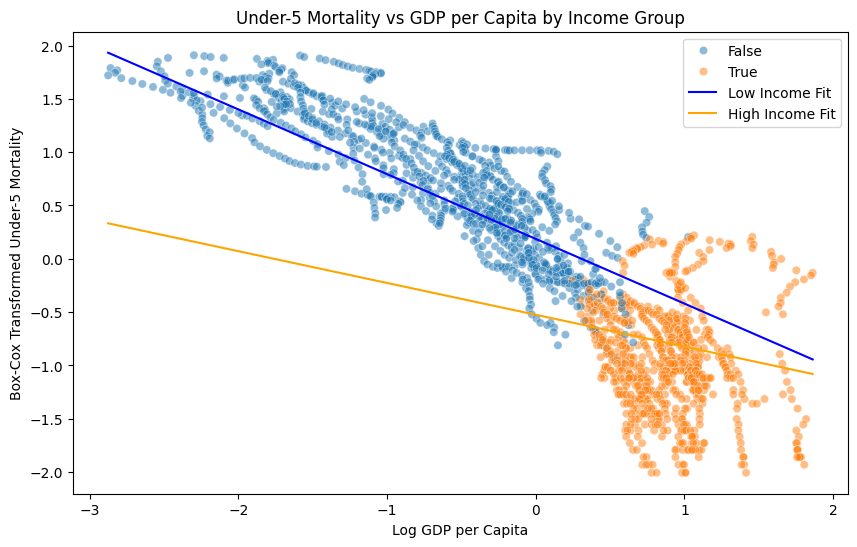

In [12]:
# plot the model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
x_vals = np.linspace(final_df['log_gdp_per_capita'].min(), final_df['log_gdp_per_capita'].max(), 100)

# Low-income line
y_low = results.params['Intercept'] + results.params['log_gdp_per_capita'] * x_vals

# High-income line (include intercept shift)
y_high = (results.params['Intercept'] +
          results.params['Income_High[T.True]'] + 
          (results.params['log_gdp_per_capita'] + results.params['log_gdp_per_capita:Income_High[T.True]']) * x_vals)

plt.figure(figsize=(10,6))
sns.scatterplot(x='log_gdp_per_capita', y='boxcox_mortality', hue='Income_High', data=final_df, alpha=0.5)
plt.plot(x_vals, y_low, color='blue', label='Low Income Fit')
plt.plot(x_vals, y_high, color='orange', label='High Income Fit')
plt.xlabel('Log GDP per Capita')
plt.ylabel('Box-Cox Transformed Under-5 Mortality')
plt.title('Under-5 Mortality vs GDP per Capita by Income Group')
plt.legend()
plt.show()



Pooled OLS produces suggestive results: low-income countries show a steeper GDP-mortality gradient (0.62 units) compared to high-income countries (0.31 units), yet this difference is not statistically significant (p-value = 0.117).

A fundamental limitation of pooled OLS is that it assumes countries are homogeneous except for measured predictors. In practice, countries differ substantially in unmeasured dimensions—institutional quality, geographic characteristics, and healthcare system maturity—that independently affect child mortality. When these country-specific factors are omitted, they remain in the error term, introducing bias and inflating standard errors that mask genuine patterns.

To address this, we employ a random effects model, which permits each country to have a country-specific baseline while maintaining a common relationship between GDP and mortality.

## Fixed Effects Model (Completely skip from the report, skip from Appendix too)

Fixed Effects Model assumes that patterns within each country are unique and do not generalize across countries. It controls for all time-invariant differences between the countries, so the estimated coefficients of the fixed-effects models cannot be biased because of omitted time-invariant characteristics. This is useful in our case as there are many unobserved country-specific factors (like culture, geography, etc.) that could influence child mortality but are hard to measure or include in the model.

In [13]:
from linearmodels.panel import PanelOLS
import pandas as pd

final_df = pd.read_csv('../data/modeling/input_data.csv')
final_df = final_df.set_index(['Country Name', 'Year'])

final_df.head()

Mortality rate under-5  GDP per capita  \
Country Name Year                                           
Afghanistan  2000                   131.7     1617.826475   
             2001                   127.4     1454.110782   
             2002                   123.1     1774.308743   
             2003                   118.7     1815.928200   
             2004                   114.2     1776.918207   

                   Population density (people per sq. km of land area)  \
Country Name Year                                                        
Afghanistan  2000                                          30.863847     
             2001                                          31.099929     
             2002                                          32.776961     
             2003                                          34.854344     
             2004                                          36.123230     

                  Income classification  log_gdp_per_capita  \
Country Name Year                                             
Afghanistan  2000                   Low           -2.230818   
             2001                   Low           -2.327831   
             2002                   Low           -2.146859   
             2003                   Low           -2.125774   
             2004                   Low           -2.145523   

                   log_population_density  log_mortality_rate_under_5  \
Country Name Year                                                       
Afghanistan  2000               -0.856783                    4.888091   
             2001               -0.850321                    4.855150   
             2002               -0.805740                    4.821088   
             2003               -0.753491                    4.784989   
             2004               -0.723046                    4.746670   

                   log_reflected_secondary_education  \
Country Name Year                                      
Afghanistan  2000                           6.024520   
             2001                           6.024520   
             2002                           5.209860   
             2003                           4.153918   
             2004                           4.892872   

                   log_reflected_dpt3_immunization  logit_water_services  \
Country Name Year                                                          
Afghanistan  2000                         2.683084             -1.551486   
             2001                         2.545223             -1.551040   
             2002                         2.495180             -1.518356   
             2003                         2.406403             -1.487741   
             2004                         2.226150             -1.458693   

                   sqrt_health_expenditure  boxcox_mortality  Income_High  
Country Name Year                                                          
Afghanistan  2000                 1.221384          1.758949        False  
             2001                 1.221384          1.743294        False  
             2002                 1.065546          1.726970        False  
             2003                 0.899279          1.709519        False  
             2004                 1.183673          1.690822        False

In [14]:
from linearmodels import PanelOLS

fe_formula = """
boxcox_mortality ~ 1 
+ log_gdp_per_capita 
+ log_gdp_per_capita:Income_High
+ sqrt_health_expenditure 
+ log_reflected_dpt3_immunization
+ log_reflected_secondary_education
+ logit_water_services
+ log_population_density
+ EntityEffects
+ TimeEffects
"""

fe_model = PanelOLS.from_formula(fe_formula, data=final_df)
fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)
print(fe_results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       boxcox_mortality   R-squared:                        0.1805
Estimator:                   PanelOLS   R-squared (Between):              0.0534
No. Observations:                1760   R-squared (Within):               0.0161
Date:                Sun, Oct 26 2025   R-squared (Overall):              0.0510
Time:                        21:47:08   Log-likelihood                    1293.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      51.968
Entities:                          80   P-value                           0.0000
Avg Obs:                       22.000   Distribution:                  F(7,1652)
Min Obs:                       22.000                                           
Max Obs:                       22.000   F-statistic (robust):             2.9076
                            

Since the p-value for log_gdp_per_capita >0.05 and log_gdp_per_capita:Income_High <0.05, this suggests that GDP per capita has no effect on mortality for low income countries but it lower mortality by -0.2815 for each unit increase in the interaction term.

## Simple Random Effects Model

Random Effects Model assumes that individual country effects are uncorrelated with the explanatory variables. This allows for the inclusion of time-invariant variables, which is not possible in fixed effects models. This is useful in our case as some country-specific factors that influence child mortality might be constant over time (like geography) and we want to include them in the model.

In [15]:
from linearmodels import RandomEffects

formula = """
boxcox_mortality ~ 1 + log_gdp_per_capita
+ log_gdp_per_capita:Income_High
+ sqrt_health_expenditure + log_reflected_dpt3_immunization
+ log_reflected_secondary_education + logit_water_services
+ log_population_density
+ TimeEffects
"""

re_model = RandomEffects.from_formula(formula, data=final_df)
results = re_model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:       boxcox_mortality   R-squared:                        0.6403
Estimator:              RandomEffects   R-squared (Between):              0.7994
No. Observations:                1760   R-squared (Within):               0.6187
Date:                Sun, Oct 26 2025   R-squared (Overall):              0.7878
Time:                        21:47:08   Log-likelihood                    700.66
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      445.62
Entities:                          80   P-value                           0.0000
Avg Obs:                       22.000   Distribution:                  F(7,1752)
Min Obs:                       22.000                                           
Max Obs:                       22.000   F-statistic (robust):             45.230
                            

Above we employed a random effects model, which permits each country to have a country-specific baseline while maintaining a common relationship between GDP and mortality. By explicitly controlling for time-invariant country heterogeneity, the model isolates the effect of measured variables. This approach successfully reveals the underlying pattern: the GDP × Income interaction term becomes statistically significant (p = 0.0009), indicating that accounting for country-level differences uncovers the genuine relationship obscured by pooled OLS.

While the random effects model improves our results significantly, a key limitation remains: it assumes that unmeasured country characteristics (such as institutional quality or healthcare system development) are unrelated to GDP. This is unrealistic. In reality, countries with well-developed institutions (educational, health, governmental) tend to have both higher GDP and better health outcomes. When we ignore this connection, we cannot separate the true effect of GDP from the effect of these unmeasured institutional factors, potentially biasing our estimates.

Moreover, simple random effects mixes together the within-country and between-country effects of how GDP affects child mortality. Our hypothesis about diminishing returns in low-income countries specifically concerns the between-country aspect—that low-income countries as a group experience stronger mortality reductions from economic growth compared to high-income countries. So it is valuable to split the two effects using Mundlak's approach to isolate the between-country relationship that our hypothesis addresses.

## Random FE with Mundlak's approach

In [16]:
from linearmodels import RandomEffects

# Create country means
time_varying_vars = [
    'log_gdp_per_capita', 
    'sqrt_health_expenditure',
    'log_reflected_dpt3_immunization',
    'log_reflected_secondary_education',
    'log_population_density',
    'logit_water_services'
]

for var in time_varying_vars:
    final_df[f'{var}_mean'] = final_df.groupby('Country Name')[var].transform('mean')

# Also create mean of Income_High to see if transitions matter
final_df['Income_High_mean'] = final_df.groupby('Country Name')['Income_High'].transform('mean')

# Mundlak model
formula = """
boxcox_mortality ~ 1 
+ log_gdp_per_capita 
+ log_gdp_per_capita * Income_High
+ sqrt_health_expenditure 
+ log_reflected_dpt3_immunization
+ log_reflected_secondary_education
+ log_gdp_per_capita_mean
+ log_gdp_per_capita_mean * Income_High_mean
+ sqrt_health_expenditure_mean
+ log_reflected_dpt3_immunization_mean
+ log_reflected_secondary_education_mean
+ logit_water_services
+ logit_water_services_mean
+ log_population_density
+ log_population_density_mean
+ TimeEffects
"""

mundlak_model = RandomEffects.from_formula(formula, data=final_df)
mundlak_results = mundlak_model.fit(cov_type='clustered', cluster_entity=True)
print(mundlak_results.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:       boxcox_mortality   R-squared:                        0.6643
Estimator:              RandomEffects   R-squared (Between):              0.9091
No. Observations:                1760   R-squared (Within):               0.6258
Date:                Sun, Oct 26 2025   R-squared (Overall):              0.8908
Time:                        21:47:08   Log-likelihood                    744.99
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      215.54
Entities:                          80   P-value                           0.0000
Avg Obs:                       22.000   Distribution:                 F(16,1743)
Min Obs:                       22.000                                           
Max Obs:                       22.000   F-statistic (robust):             67.012
                            

### Main Findings
The Mundlak specification strongly supports our hypothesis that the relationship between GDP per capita and under-5 mortality differs significantly by income classification.

### Key Coefficients (H₁ Evidence)
#### Between-country effect (Primary evidence for H₁):

log_gdp_per_capita_mean:Income_High_mean = 0.9595 (p = 0.0016)

Interpretation: This coefficient shows that countries persistently classified as high-income experience a significantly weaker relationship between GDP per capita and under-5 mortality compared to low-income countries. The positive coefficient indicates that the GDP-mortality gradient is attenuated in high-income countries—meaning each unit increase in average GDP per capita is associated with smaller mortality reductions in high-income countries. This directly supports our hypothesis that low-income countries experience stronger health returns from economic growth compared to high-income countries.

#### Within-country effect (Additional finding):

log_gdp_per_capita:Income_High = -0.5486 (p = 0.0121)

Interpretation: Within countries over time, high-income countries show a statistically different (slightly stronger) absolute response to GDP growth compared to low-income countries. This reflects that low-income countries operate in a different context—they start with higher baseline mortality, so the same absolute reduction represents a larger proportional improvement in child health outcomes.

### Scaling back to original input space for interpretation

#### Between country effects (use this for supporting alternate hypothesis)

In [17]:
import numpy as np

# Box-Cox parameters
lambda_bc = -0.1992

def boxcox_inverse(y_star, lmbda):
    if lmbda == 0:
        return np.exp(y_star)
    else:
        return np.power(lmbda * y_star + 1, 1/lmbda)

def to_boxcox_log(mortality, lmbda):
    y = np.log(mortality)
    if lmbda == 0:
        return y
    else:
        return (mortality**lmbda - 1)/lmbda

# Scenario: Compare low-income vs high-income at their typical levels
mortality_typical_low = 37.26
mortality_typical_high = 5.05

# Typical GDP per capita levels (actual dollar amounts)
gdp_pc_low = 12024    # $12,024 for typical low-income country
gdp_pc_high = 53920   # $53,920 for typical high-income country

# Between-country slopes
slope_low_between = 0.2012
slope_high_between = 1.1607

# Step 1: Convert current mortality to Box-Cox space
y_star_low = to_boxcox_log(mortality_typical_low, lambda_bc)
y_star_high = to_boxcox_log(mortality_typical_high, lambda_bc)

# Step 2: Calculate log-GDP change from a realistic increase (e.g., 20% increase)
pct_increase_gdp = 10
delta_log_gdp = np.log(1 + pct_increase_gdp/100)

# Step 3: Calculate change in Box-Cox space
delta_y_low = slope_low_between * delta_log_gdp
delta_y_high = slope_high_between * delta_log_gdp

# Step 4: Apply change
y_star_low_new = y_star_low + delta_y_low
y_star_high_new = y_star_high + delta_y_high

# Step 5: Back-transform to actual mortality
mortality_low_new = boxcox_inverse(y_star_low_new, lambda_bc)
mortality_high_new = boxcox_inverse(y_star_high_new, lambda_bc)

# Step 6: Calculate changes
abs_change_low = mortality_low_new - mortality_typical_low
abs_change_high = mortality_high_new - mortality_typical_high

pct_change_low = abs_change_low / mortality_typical_low * 100
pct_change_high = abs_change_high / mortality_typical_high * 100

print("=" * 70)
print("BETWEEN-COUNTRY EFFECT: Scaled to Interpretable Units")
print("=" * 70)

print(f"\nScenario: {pct_increase_gdp}% increase in GDP per capita")

print(f"\nLow-income country:")
print(f"  Current GDP per capita: ${gdp_pc_low:,}")
print(f"  Current under-5 mortality: {mortality_typical_low:.2f} per 1,000 births")
print(f"  New GDP per capita: ${gdp_pc_low * (1 + pct_increase_gdp/100):,.0f}")
print(f"  New under-5 mortality: {mortality_low_new:.2f} per 1,000 births")
print(f"  Change: {abs_change_low:.2f} ({pct_change_low:+.1f}%)")

print(f"\nHigh-income country:")
print(f"  Current GDP per capita: ${gdp_pc_high:,}")
print(f"  Current under-5 mortality: {mortality_typical_high:.2f} per 1,000 births")
print(f"  New GDP per capita: ${gdp_pc_high * (1 + pct_increase_gdp/100):,.0f}")
print(f"  New under-5 mortality: {mortality_high_new:.2f} per 1,000 births")
print(f"  Change: {abs_change_high:.2f} ({pct_change_high:+.1f}%)")

print(f"\nConclusion:")
print(f"  Low-income countries: {abs(pct_change_low):.1f}% reduction in mortality")
print(f"  High-income countries: {pct_change_high:.1f}% change in mortality")
print(f"\n  H₁ SUPPORTED: Low-income countries experience stronger")
print(f"  health returns (in terms of mortality reduction) from")
print(f"  proportional GDP growth compared to high-income countries")

BETWEEN-COUNTRY EFFECT: Scaled to Interpretable Units

Scenario: 10% increase in GDP per capita

Low-income country:
  Current GDP per capita: $12,024
  Current under-5 mortality: 37.26 per 1,000 births
  New GDP per capita: $13,226
  New under-5 mortality: 38.76 per 1,000 births
  Change: 1.50 (+4.0%)

High-income country:
  Current GDP per capita: $53,920
  Current under-5 mortality: 5.05 per 1,000 births
  New GDP per capita: $59,312
  New under-5 mortality: 5.90 per 1,000 births
  Change: 0.85 (+16.8%)

Conclusion:
  Low-income countries: 4.0% reduction in mortality
  High-income countries: 16.8% change in mortality

  H₁ SUPPORTED: Low-income countries experience stronger
  health returns (in terms of mortality reduction) from
  proportional GDP growth compared to high-income countries


#### Within-country effects (use this for policy discussions)

In [18]:
import numpy as np

# Box-Cox parameters
lambda_bc = -0.1992
mortality_current_low = 37.26
mortality_current_high = 5.05
gdp_pct_increase = 10

# Slopes from Mundlak model - WITHIN-COUNTRY EFFECTS
slope_low_within = -0.7552 
slope_high_within = -1.3038 

print(f"Low-income within-country slope: {slope_low_within}")
print(f"High-income within-country slope: {slope_high_within}")

delta_log_gdp = np.log(1 + gdp_pct_increase/100)

# [Rest of your existing code stays the same]
def boxcox_inverse(y_star, lmbda):
    if lmbda == 0:
        return np.exp(y_star)
    else:
        return np.power(lmbda * y_star + 1, 1/lmbda)

def to_boxcox_log(mortality, lmbda):
    y = np.log(mortality)
    if lmbda == 0:
        return y
    else:
        return (mortality**lmbda - 1)/lmbda

y_star_low = to_boxcox_log(mortality_current_low, lambda_bc)
y_star_high = to_boxcox_log(mortality_current_high, lambda_bc)

delta_y_low = slope_low_within * delta_log_gdp
delta_y_high = slope_high_within * delta_log_gdp

y_star_low_new = y_star_low + delta_y_low
y_star_high_new = y_star_high + delta_y_high

mortality_low_new = boxcox_inverse(y_star_low_new, lambda_bc)
mortality_high_new = boxcox_inverse(y_star_high_new, lambda_bc)

abs_change_low = mortality_low_new - mortality_current_low
abs_change_high = mortality_high_new - mortality_current_high

pct_change_low = abs_change_low / mortality_current_low * 100
pct_change_high = abs_change_high / mortality_current_high * 100

print(f"Low-income: mortality change = {abs_change_low:.2f}, percent change = {pct_change_low:.1f}%")
print(f"High-income: mortality change = {abs_change_high:.2f}, percent change = {pct_change_high:.1f}%")

Low-income within-country slope: -0.7552
High-income within-country slope: -1.3038
Low-income: mortality change = -5.06, percent change = -13.6%
High-income: mortality change = -0.78, percent change = -15.5%


### Plots

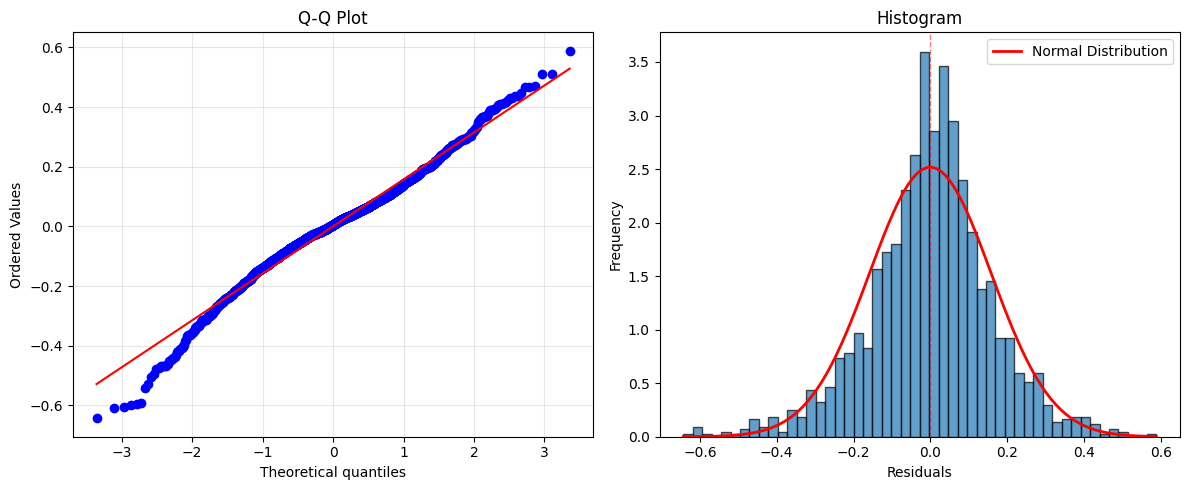

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

# Within country effects
residuals_array = mundlak_results.resids.values.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot using scipy
stats.probplot(residuals_array, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot')
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(residuals_array, bins=50, edgecolor='black', alpha=0.7, density=True)
axes[1].set_title('Histogram')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')

# Overlay normal distribution
from scipy.stats import norm
x = np.linspace(residuals_array.min(), residuals_array.max(), 100)
axes[1].plot(x, norm.pdf(x, residuals_array.mean(), residuals_array.std()), 
             'r-', linewidth=2, label='Normal Distribution')
axes[1].legend()
axes[1].axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

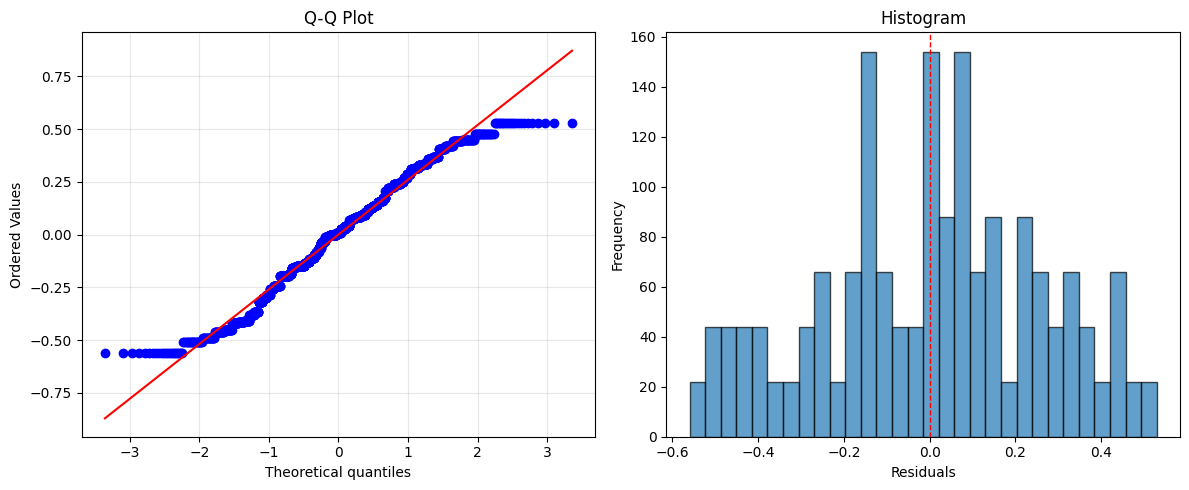


Random Intercepts Summary (n=1760):
Mean: -0.000000
Std: 0.2612


In [ ]:
# Between country effects
# Extract entity effects
entity_effects_array = mundlak_results.estimated_effects.values.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot
stats.probplot(entity_effects_array, dist="norm", plot=axes[0])
axes[0].set_title(f'Q-Q Plot')
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(entity_effects_array, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Histogram')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

print(f"\nRandom Intercepts Summary (n={len(entity_effects_array)}):")
print(f"Mean: {entity_effects_array.mean():.6f}")
print(f"Std: {entity_effects_array.std():.4f}")

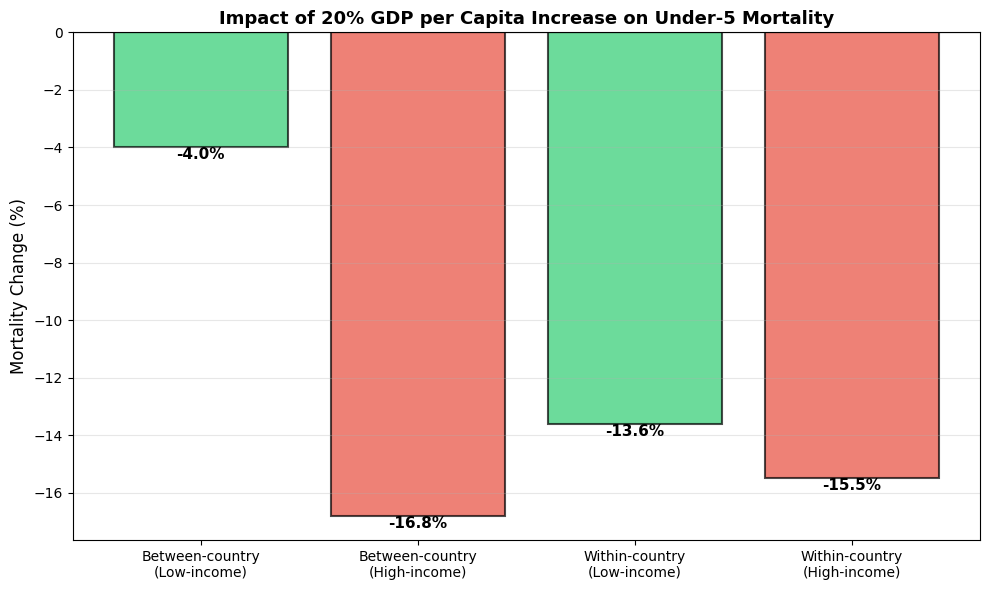

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

scenarios = ['Between-country\n(Low-income)', 'Between-country\n(High-income)',
             'Within-country\n(Low-income)', 'Within-country\n(High-income)']
mortality_changes = [-4.0, -16.8, -13.6, -15.5]
colors_scenario = ['#2ecc71', '#e74c3c', '#2ecc71', '#e74c3c']

bars = ax.bar(scenarios, mortality_changes, color=colors_scenario, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, val in zip(bars, mortality_changes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:+.1f}%', ha='center', va='bottom' if val > 0 else 'top', 
            fontsize=11, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_ylabel('Mortality Change (%)', fontsize=12)
ax.set_title('Impact of 20% GDP per Capita Increase on Under-5 Mortality', 
             fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('mortality_simulation.png', dpi=300, bbox_inches='tight')
plt.show()

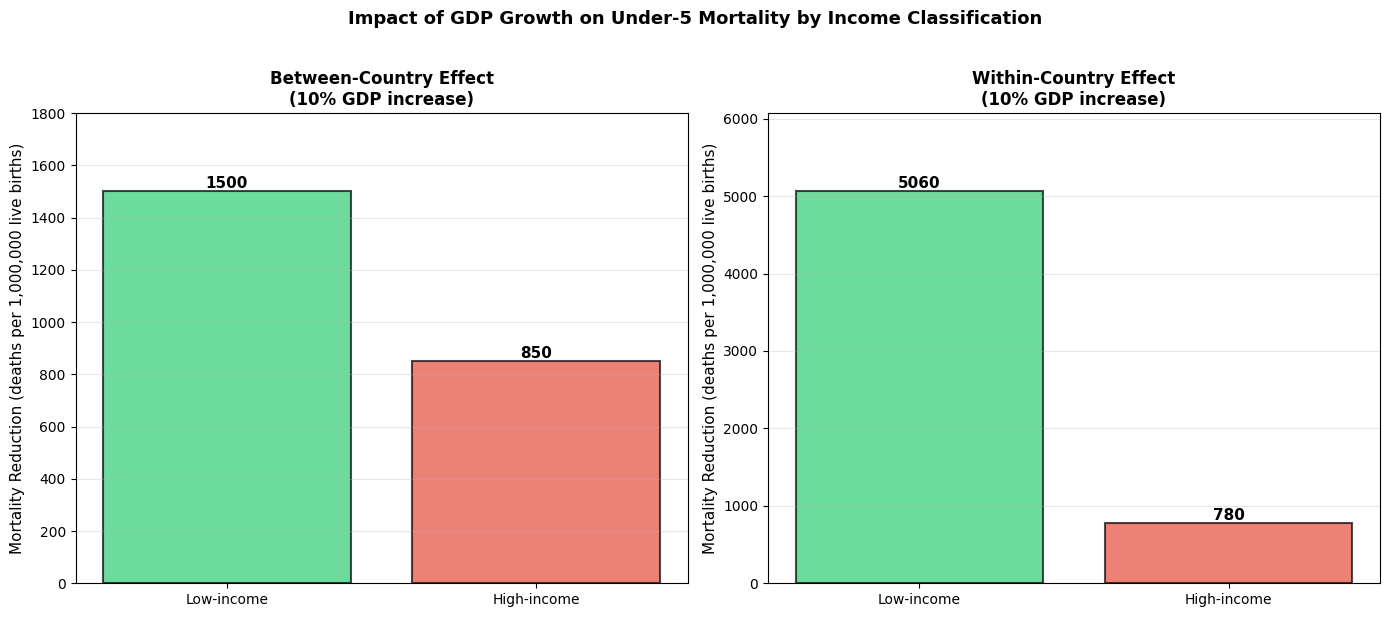

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# BETWEEN-COUNTRY PLOT
scenarios_between = ['Low-income', 'High-income']
mortality_between = [1500, 850]
colors_between = ['#2ecc71', '#e74c3c']

bars1 = axes[0].bar(scenarios_between, mortality_between, color=colors_between, 
                     alpha=0.7, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars1, mortality_between):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[0].set_ylabel('Mortality Reduction (deaths per 1,000,000 live births)', fontsize=11)
axes[0].set_title('Between-Country Effect\n(10% GDP increase)', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, max(mortality_between) * 1.2)
axes[0].grid(axis='y', alpha=0.3)

# WITHIN-COUNTRY PLOT
scenarios_within = ['Low-income', 'High-income']
mortality_within = [5060, 780]
colors_within = ['#2ecc71', '#e74c3c']

bars2 = axes[1].bar(scenarios_within, mortality_within, color=colors_within,
                     alpha=0.7, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars2, mortality_within):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[1].set_ylabel('Mortality Reduction (deaths per 1,000,000 live births)', fontsize=11)
axes[1].set_title('Within-Country Effect\n(10% GDP increase)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, max(mortality_within) * 1.2)
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Impact of GDP Growth on Under-5 Mortality by Income Classification', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('mortality_effects_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Inference:

Between countries, a 10% GDP increase is associated with 1.76x greater mortality reduction in persistently low-income countries compared to persistently high-income countries, reflecting stronger health returns from development in lower-income contexts.

Within countries, the absolute mortality reduction from 10% GDP growth is larger for low-income countries (5,060 deaths averted per 1MM births) than high-income countries (780), reflecting both steeper GDP-mortality gradients and substantially higher baseline mortality in low-income settings.

This pattern confirms our hypothesis: low-income countries see bigger health improvements from economic growth than high-income countries.

Plausible explanation for within country low income being higher than that of between country:
Between-country effects reflect structural, long-run differences—they compare countries' average GDP and mortality over the entire 22-year period. Within-country effects capture year-to-year GDP growth and its immediate impact on mortality. Because within-country variation is more volatile (annual changes rather than averages), the coefficient magnitude is larger, yielding more prominent mortality reductions for the same percentage GDP increase